In [1]:
# -*- coding: utf-8 -*-
### Required libraries ------------------------------------------
import numpy as np
import os
import pandas as pd
from pandas import Series

# column 다 보이기
pd.set_option('display.max_columns', None)
#(참고) warning 제거를 위한 코드
#np.seterr(divide='ignore', invalid='ignore')

### Visualization libraries -------------------------------------
import seaborn as sns
color = sns.color_palette()
#sns.set_style('darkgrid')    #ticks

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (7,6)  # 크기 (inch)
plt.rcParams['axes.grid'] = True        # 격자선 여부
plt.rcParams['lines.linewidth'] = 2     # 선의 두께
plt.rcParams['lines.color'] = 'red'     # 선의 색깔

### Etc. libraries ----------------------------------------------
from datetime import datetime    # To access datetime 
# To print multiple output in a cell --------------------------
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

### *************************************************************


In [2]:
#!pip install opencv-python
import cv2
import time

#!pip install vidgear
from vidgear.gears import WriteGear

# 4.5이상
print(cv2.__version__)

# !pip install --trusted-host pypi.python.org moviepy
# !pip install imageio-ffmpeg

4.5.2


* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행.

# 1. SSD+Inception 기반 

# 1-1) Object Detection 수행 - Image

In [ ]:
!mkdir ./data

!wget -O ./data/rose.jpg \
         https://thumb.mt.co.kr/06/2020/10/2020101522424982247_3.jpg


image shape: (680, 680, 3)


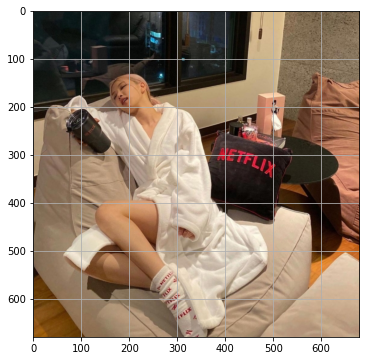

In [25]:
input_img_path='./data/rose.jpg'
img = cv2.imread(input_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)

# 1-2) Object Detection 수행  - Video

In [ ]:
# !pip install --trusted-host pypi.python.org moviepy
# !pip install imageio-ffmpeg

#!wget -O ./data/John_Wick_small1.mp4  \
#        https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

#!cp /workspace/data/hanwoo/Hanwoo_D10_20210606130000.mp4 ./data/Hanwoo_D10.mp4
#!cp /workspace/data/hanwoo/Hanwoo_D03_20210606125959.mp4 ./data/Hanwoo_D03.mp4

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("./data/Hanwoo_D03.mp4", 300, 306, targetname="./data/Hanwoo_D03_cut.mp4")  #360


In [4]:
input_video_path = './data/Hanwoo_D03_cut.mp4'
#input_video_path = './data/John_Wick_small.mp4'
vcap = cv2.VideoCapture(input_video_path) # 0=camera
if vcap.isOpened(): 
    v_width  = vcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width`
    v_height = vcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height`
    v_fps = vcap.get(cv2.CAP_PROP_FPS)
    v_fcnt= vcap.get(cv2.CAP_PROP_FRAME_COUNT)
print(v_width,v_height,v_fps,v_fcnt)

2944.0 1656.0 20.0 120.0


In [5]:
from IPython.display import Video
Video(input_video_path, width=v_width/4, height=v_height/4)

In [16]:
cap = cv2.VideoCapture(input_video_path)

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt)

총 Frame 갯수: 120


##  2) OpenCV에서 Inference모델 생성 (다운받은 모델파일과 환경파일을 활용)

### 모델파일과 환경파일 다운로드
다운로드 URL : https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API
 - Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)
   pretrained 모델 (weight파일) 다운로드 후 , 압축해제
 - (pretrained 모델을 위한) 환경파일 다운로드 url
 
* https://github.com/opencv/opencv/pull/16760 
* dnn_DetectionModel()은 dnn_Model 객체 반환
* 해당 SSD 모델은 image pixel값을 -1 ~ 1 사이로 정규화하고 image size는 320, 320으로 설정.

In [6]:
!mkdir ./pretrained

!wget -O ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz \
        http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 
!tar -xvf ./pretrained/ssd_inception*.tar.gz -C ./pretrained 

!wget -O ./pretrained/ssd_config_01.pbtxt  \
        https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
    

mkdir: cannot create directory ‘./pretrained’: File exists
--2021-07-21 08:22:53--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.25.80, 2404:6800:4004:818::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.25.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’

./pretrained/ssd_in 100%[===================>] 265.24M  34.6MB/s    in 8.8s    

2021-07-21 08:23:03 (30.0 MB/s) - ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

ssd_inception_v2_coco_2017_11_17/
ssd_inception_v2_coco_2017_11_17/model.ckpt.index
ssd_inception_v2_coco_2017_11_17/model.ckpt.meta
ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb
ssd_inception_v2_coco_2017_11_17/model.ckpt.data-00000-of-00001
ssd_ince

In [7]:
!pwd
!ls -lia ./pretrained/ssd_inception*

/workspace/git/DLCV/one
77333248 -rw-r--r-- 1 root   root 278126337 Nov 18  2017 ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz

./pretrained/ssd_inception_v2_coco_2017_11_17:
total 201120
77333249 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 .
77333230 drwxr-xr-x 4 root   root      4096 Jul 21 08:23 ..
77333257 -rw-r----- 1 275875 5000        77 Nov 18  2017 checkpoint
77333252 -rw-r----- 1 275875 5000 101987441 Nov 18  2017 frozen_inference_graph.pb
77333253 -rw-r----- 1 275875 5000 100214372 Nov 18  2017 model.ckpt.data-00000-of-00001
77333250 -rw-r----- 1 275875 5000     18073 Nov 18  2017 model.ckpt.index
77333251 -rw-r----- 1 275875 5000   3701354 Nov 18  2017 model.ckpt.meta
77333254 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 saved_model


#### Model파일과 config파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 
즉, DNN의 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [8]:
cv_net = cv2.dnn.readNetFromTensorflow(
    './pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb',
    './pretrained/ssd_config_01.pbtxt'
)

In [ ]:
# cv_net_m.setInputSize(320, 320)
# #cv_net_m.setInputSize(v_width, v_height)
# cv_net_m.setInputScale(1.0 / 127.5)
# cv_net_m.setInputMean((127.5, 127.5, 127.5))
# cv_net_m.setInputSwapRB(True)

## 3) get_detected_img

### 3-1) 이미지 preprocessing 수행후, Network에 입력

### dnn_Model 객체의 detect() 메소드는 입력 이미지를 받아서 특정 confidence threshold 이상의 모든 object inference 결과를 반환. 
* class id값, confidence score값, bbox 좌표값이 arrary로 반환됨.
* bbox 좌표값의 경우 0~1사이 값이 아니라 정수형의 위치값이 반환됨. 단 xmin, ymin, width, height 형태로 반환되므로 유의 필요. 

### 3-2) Object Detection 수행 후, 결과를 이미지에 시각화

#### coco데이터셋의 Classid별 ClassName 지정. 

In [10]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


In [44]:
def get_detected_img(cv_net, img_array, score_threshold, is_print=True):
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    draw_img = img_array.copy()

    start = time.time()
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300), swapRB=True, crop=False))
    cv_out = cv_net.forward()
    
    color_green=(0, 255,   0)
    color_red  =(0,   0, 255)

    for detection in cv_out[0,0,:,:]:
        class_id =   int(detection[1])
        score    = float(detection[2])
        if score > score_threshold:
            left   = detection[3] * cols
            top    = detection[4] * rows
            right  = detection[5] * cols
            bottom = detection[6] * rows
            #coco dataset 클래스명 매핑
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
            # Object Detetion 수행 후 시각화
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=color_green, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_red, 2)
            
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img


Detection 수행시간: 0.06 초


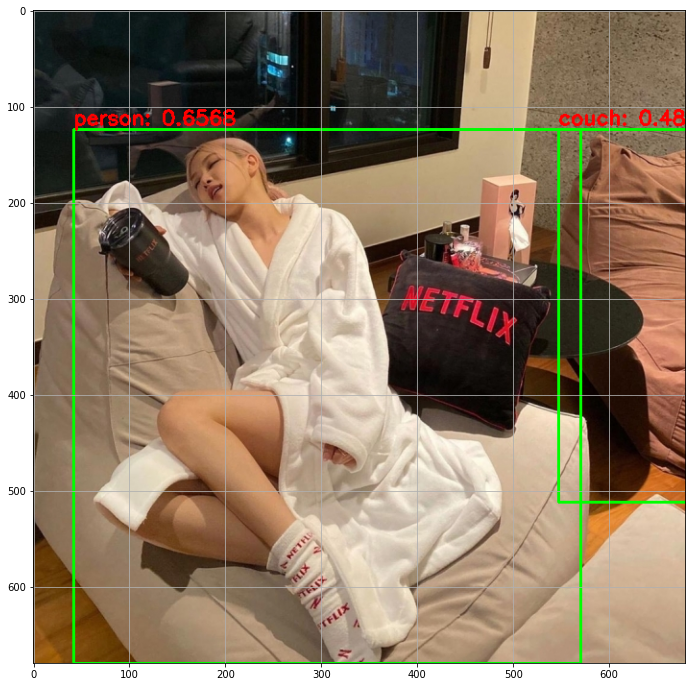

In [14]:
input_img_path='./data/rose.jpg'
img = cv2.imread(input_img_path)

draw_img = get_detected_img(cv_net, img, score_threshold=0.4, is_print=True)
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### 3-2) dnn_Model을 만드는 함수 생성.

In [ ]:
# def get_cv_detection_model(pretrained_path, config_path):
#     cv_net = cv2.dnn_DetectionModel(pretrained_path, config_path)
#     cv_net.setInputSize(320, 320)
#     cv_net.setInputScale(1.0 / 127.5)
#     cv_net.setInputMean((127.5, 127.5, 127.5))
#     cv_net.setInputSwapRB(True)
  
#     return cv_net

# cv_net_m = get_cv_detection_model(
#     './pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
#     './pretrained/ssd_config_02.pbtxt')

### 4) Video Detection용 전용 함수 생성 - Video Inferece 수행.

In [17]:
# def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    
#     cap   = cv2.VideoCapture(input_path)
#     codec = cv2.VideoWriter_fourcc(*'XVID')

#     vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
#     vid_fps  = cap.get(cv2.CAP_PROP_FPS)

#     vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

#     frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     print('총 Frame 갯수:', frame_cnt, )

#     green_color=(0, 255, 0)
#     red_color=(0, 0, 255)
    
#     while True:
#         hasFrame, img_frame = cap.read()
#         if not hasFrame:
#             print('더 이상 처리할 frame이 없습니다.')
#             break
        
#         returned_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, is_print=True)
#         vid_writer.write(returned_frame)
#     # end of while loop

#     vid_writer.release()
#     cap.release()


In [45]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    
    stream= cv2.VideoCapture(input_path)
    output_params = {"-vcodec":"libx264", "-crf": 0, "-preset": "fast"}
    writer = WriteGear(output_path, logging=True, **output_params)

    frame_cnt = int(stream.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )
    
    while True:
        (hasFrame, frame) = stream.read()
        if not hasFrame:
            print('End of the frame. done.'); break
        
        returned_frame = get_detected_img(cv_net, frame, score_threshold, is_print=is_print)
        writer.write(returned_frame)
    # end of while loop

    cv2.destroyAllWindows()
    stream.release()
    writer.close()

## 5) 결과확인

In [46]:
#do_detected_video_renew(cv_net_m, './data/Jonh_Wick_small.mp4', './data/John_Wick_small_m3.mp4', 0.2, False)

output_video_path = './data/Hanwoo_D03_cut_output.mp4'
#output_video_path = './data/J_output.mp4'

do_detected_video(
    cv_net=cv_net, 
    input_path =input_video_path, 
    output_path=output_video_path, 
    score_threshold=0.2, 
    is_print=False
)


12:29:50 :: WriteGear :: DEBUG :: Compression Mode is enabled therefore checking for valid FFmpeg executables.
12:29:50 :: WriteGear :: DEBUG :: Output Parameters: {'-vcodec': 'libx264', '-crf': 0, '-preset': 'fast'}
12:29:50 :: Helper :: DEBUG :: Final FFmpeg Path: ffmpeg
12:29:50 :: Helper :: DEBUG :: FFmpeg validity Test Passed!
12:29:50 :: Helper :: DEBUG :: Found valid FFmpeg Version: `b'3.4.8-0ubuntu0.2'` installed on this system
12:29:50 :: WriteGear :: DEBUG :: Found valid FFmpeg executables: `ffmpeg`.
12:29:50 :: WriteGear :: DEBUG :: Compression Mode is configured properly!


총 Frame 갯수: 120


12:29:50 :: WriteGear :: DEBUG :: InputFrame => Height:1656 Width:2944 Channels:3
12:29:50 :: WriteGear :: DEBUG :: Executing FFmpeg command: `ffmpeg -y -f rawvideo -vcodec rawvideo -s 2944x1656 -pix_fmt bgr24 -i - -vcodec libx264 -crf 0 -preset fast /workspace/git/DLCV/one/data/Hanwoo_D03_cut_output.mp4`
12:30:01 :: WriteGear :: DEBUG :: Terminating WriteGear Processes.


End of the frame. done.


In [47]:
from IPython.display import Video
Video(output_video_path, width=v_width/4, height=v_height/4)


In [28]:
!pwd
!ls -lia ./data

/workspace/git/DLCV/one
total 1137072
77333228 drwxr-xr-x 3 root root      4096 Jul 21 08:07 .
77203173 drwxr-xr-x 6 root root      4096 Jul 21 12:03 ..
77333241 drwxr-xr-x 2 root root      4096 Jul 21 06:54 .ipynb_checkpoints
77333243 -rw-r--r-- 1 root root 391716803 Jul 21 06:54 Hanwoo_D03.mp4
77333244 -rw-r--r-- 1 root root   3431662 Jul 21 06:54 Hanwoo_D03_cut.mp4
77333245 -rw-r--r-- 1 root root  29484837 Jul 21 11:54 Hanwoo_D03_cut_output.mp4
77333242 -rw-r--r-- 1 root root 737594948 Jul 21 06:54 Hanwoo_D10.mp4
77333246 -rw-r--r-- 1 root root         0 Jul 21 08:07 J_output.mp4
77333247 -rw-r--r-- 1 root root   1794863 Jul 21 07:59 John_Wick_small.mp4
77333229 -rw-r--r-- 1 root root    306583 Oct 15  2020 rose.jpg
